In [67]:
!pip install tqdm
!pip install scipy

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.3.1 -> 23.3
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 5.1 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip available: 22.3.1 -> 23.3
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


100%|██████████| 6359/6359 [00:02<00:00, 2844.31count/s]


>>> Library loading completed.



100%|██████████| 6359/6359 [00:01<00:00, 5544.22count/s]


>>> Interpolation completed.



100%|██████████| 6359/6359 [00:03<00:00, 1709.99count/s]


>>> Scaling completed.



100%|██████████| 6359/6359 [00:00<00:00, 14880.07count/s]


>>> Similarity measurement completed.

     sampleID  spectrumID       pcc  band  min wavelength  max wavelength
0      target      target  1.000000   437         1.00135         3.93682
1      c1aa01  aa-a1s-001  0.402599   237         1.00135         2.55000
2      c1aa02  aa-a1s-002  0.643000   237         1.00135         2.55000
3      c1aa03  aa-a1s-003  0.455196   237         1.00135         2.55000
4      c1aa04  aa-a1s-004  0.059080   237         1.00135         2.55000
...       ...         ...       ...   ...             ...             ...
6355   c1ze31  ze-eac-031 -0.276977   320         1.00135         2.60000
6356   c1ze32  ze-eac-032 -0.294268   320         1.00135         2.60000
6357   c1ze57  ze-eac-057 -0.365441   320         1.00135         2.60000
6358   cazi01  zi-eac-001  0.158309   320         1.00135         2.60000
6359   cazi02  zi-eac-002  0.461485   320         1.00135         2.60000

[6360 rows x 6 columns]
     sampleID    spectrumID       pcc  band  min

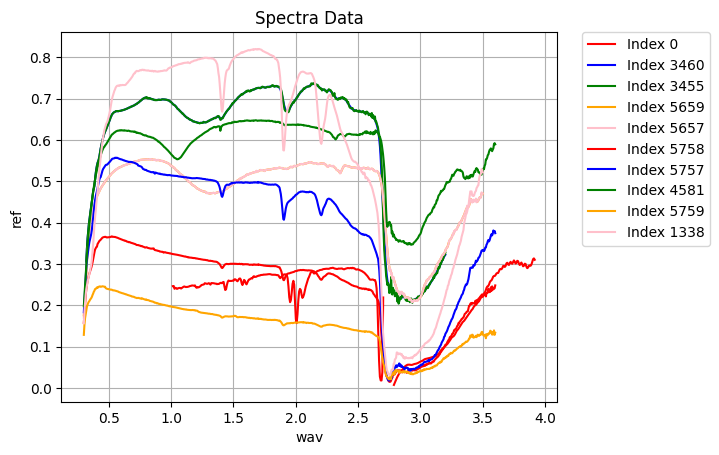

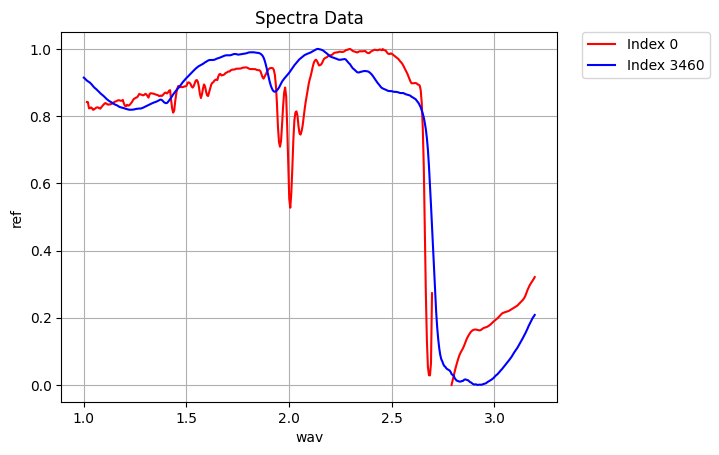

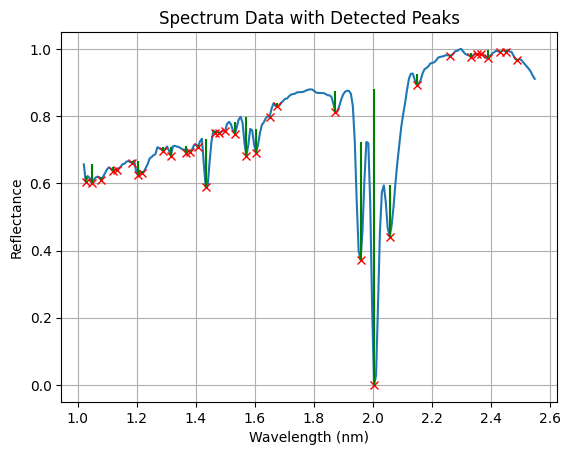

In [137]:
from tqdm import tqdm 
import csv
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_prominences


class SpectraInterpolation:
    def __init__(self, spectrumA_2d_arr, spectrumB_2d_arr):
        self.spectrumA_2d_arr = spectrumA_2d_arr
        self.spectrumB_2d_arr = spectrumB_2d_arr
        self.min_wavelength = max(spectrumA_2d_arr[0, 0], spectrumB_2d_arr[0, 0])
        self.max_wavelength = min(spectrumA_2d_arr[-1, 0], spectrumB_2d_arr[-1, 0])
        self.wavelength_step = min(np.diff(spectrumA_2d_arr[:, 0]).min(), np.diff(spectrumB_2d_arr[:, 0]).min())
        self.common_wavelength = np.arange(self.min_wavelength, self.max_wavelength, self.wavelength_step)
    
    def get_min_wavelength(self):
        return self.min_wavelength

    def get_max_wavelength(self):
        return self.max_wavelength

    def get_band(self):
        return len(self.common_wavelength)

    def liner(self):
        interpolated_refA = np.interp(self.common_wavelength, self.spectrumA_2d_arr[:, 0], self.spectrumA_2d_arr[:, 1])
        interpolated_refB = np.interp(self.common_wavelength, self.spectrumB_2d_arr[:, 0], self.spectrumB_2d_arr[:, 1])
        return pd.DataFrame({'wav':self.common_wavelength, 'refA':interpolated_refA, 'refB':interpolated_refB})


class SpectrumScaling:
    def __init__(self, ref_1d_arr):
        self.ref_1d_arr = ref_1d_arr

    def normalization(self):
        if self.ref_1d_arr.size == 0:
            return self.ref_1d_arr
        result = (self.ref_1d_arr - np.nanmin(self.ref_1d_arr)) / (np.nanmax(self.ref_1d_arr) - np.nanmin(self.ref_1d_arr))
        return result

    def standardization(self):
        if self.ref_1d_arr.size == 0:
            return self.ref_1d_arr
        result = (self.ref_1d_arr - np.nanmean(self.ref_1d_arr)) / np.nanstd(self.ref_1d_arr)
        return result


class SpectraSimilarity:
    def __init__(self, ref_df):
        self.ref_df = ref_df
        self.df_nonan = ref_df.dropna(how='any')

    def cos(self):
        if self.df_nonan.empty:
            return np.nan
        return np.dot(self.df_nonan[0], self.df_nonan[1]) / (np.linalg.norm(self.df_nonan[0]) * np.linalg.norm(self.df_nonan[1]))

    def euclid_dis(self):
        if self.df_nonan.empty:
            return np.nan
        return np.linalg.norm(self.df_nonan[0] - self.df_nonan[1])


class LibraryComparison:
    def __init__(self, library_file_path, target_file_path):
        self.library_file_path = library_file_path
        self.target_file_path = target_file_path
        self.load_library()
        self.load_target()

    def load_library(self):
        csv_file = open(self.library_file_path, 'r')
        spectrumID_list, sampleID_list, library_spectra = [], [], []
        
        for row_data in tqdm(list(csv.reader(csv_file)), unit='count'):
            spectrumID_list.append(row_data[0])
            sampleID_list.append(row_data[1])
            band = int(float(row_data[2]))
            wavelength = [float(x) for x in row_data[3:band + 3]]
            reflectance = [float(x) for x in row_data[band + 3:band * 2 + 3]]
            library_spectra.append([[x, y] for x, y in zip(wavelength, reflectance)])
        
        self.spectrumID_list = np.array(spectrumID_list, dtype='U')
        self.sampleID_list = np.array(sampleID_list, dtype='U')
        self.library_spectra = library_spectra
        csv_file.close()
        print('>>> Library loading completed.\n')

    def load_target(self):
        target_df = pd.read_csv(self.target_file_path)
        self.target_2d_arr = target_df.to_numpy()
        self.spectra_all = self.library_spectra.copy()
        self.spectra_all.insert(0, self.target_2d_arr.tolist())

    def get_normalized_arr(self):
        return self.normalized_arr

    def measure_similarity(self, interp_type, scaling_type, similarity_type):
        library_len = len(self.library_spectra)
        interpolated_df_list, min_wav_list, max_wav_list, band_list = [], [], [], []
        scaled_df_list, self.normalized_arr = [], []
        sim_results = []

        if interp_type == 'liner':
            for i in tqdm(range(library_len), unit='count'):
                interpolation = SpectraInterpolation(self.target_2d_arr, np.array(self.library_spectra[i]))
                interpolated_df_list.append(interpolation.liner())
                min_wav_list.append(interpolation.get_min_wavelength())
                max_wav_list.append(interpolation.get_max_wavelength())
                band_list.append(interpolation.get_band())
        else:
            pass

        print('>>> Interpolation completed.\n')

        if scaling_type == 'norm':
            for i in tqdm(range(library_len), unit='count'):
                scaled_target = SpectrumScaling(interpolated_df_list[i]['refA']).normalization()
                scaled_library = SpectrumScaling(interpolated_df_list[i]['refB']).normalization()
                scaled_df_list.append(pd.DataFrame({0:scaled_target, 1:scaled_library}))
                self.normalized_arr.append([interpolated_df_list[i]['wav'], scaled_target, scaled_library])
        else:
            pass

        print('>>> Scaling completed.\n')

        if similarity_type == 'pcc':
            for i in tqdm(range(library_len), unit='count'):
                sim_results.append(scaled_df_list[i].corr().iloc[1, 0])
        elif similarity_type == 'cos':
            for i in tqdm(range(library_len), unit='count'):
                sim_results.append(SpectraSimilarity(scaled_df_list[i]).cos())
        elif similarity_type == 'edis':
            for i in tqdm(range(library_len), unit='count'):
                sim_results.append(SpectraSimilarity(scaled_df_list[i]).euclid_dis())

        print('>>> Similarity measurement completed.\n')

        result_df = pd.DataFrame(
            data={'sampleID': self.sampleID_list, 
                'spectrumID': self.spectrumID_list, 
                similarity_type: sim_results, 
                'band': band_list, 
                'min wavelength': min_wav_list, 
                'max wavelength': max_wav_list}
        )
        data = [['target', 'target', 1, len(self.target_2d_arr), self.target_2d_arr[0][0], self.target_2d_arr[-1][0]]]
        target_row = pd.DataFrame(data=data, columns=result_df.columns)
        result_df = pd.concat([target_row, result_df]).reset_index(drop=True)

        return result_df
    
    def plot(self, index, sp_type):
        colors = ['red', 'blue', 'green', 'orange', 'pink']

        if sp_type == 'raw':
            for i, index in enumerate(index_list):
                x = [row[0] for row in self.spectra_all[index]]
                y = [row[1] for row in self.spectra_all[index]]
                plt.plot(x, y, color=colors[i%5], label=f'Index {index}')
        elif sp_type == 'norm':
            if index == 0:
                return print('Please specify a index other than 0.')
            # print(len(index))
            # if len(index) > 1:
            #     return print('Please specify one index.')

            plt.plot(self.normalized_arr[index-1][0], self.normalized_arr[index-1][1], color=colors[0], label=f'Index {0}')
            plt.plot(self.normalized_arr[index-1][0], self.normalized_arr[index-1][2], color=colors[1], label=f'Index {index}')

        plt.xlabel('wav')
        plt.ylabel('ref')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0) 
        plt.title('Spectra Data')
        plt.grid(True)
        plt.show()

if __name__ == "__main__":
    library_file_path = 'RelabDatabase2022Dec31/Library_Mineral_BD-VNIR.csv'
    target_file_path = 'frt00003621_07_if166l_E_-97.71906 N_24.78909.csv'
    
    comparer = LibraryComparison(library_file_path, target_file_path)
    result = comparer.measure_similarity('liner', 'norm', 'pcc')
    print(result)

    # 比較しているband数を条件適用し抽出
    result = result[result['band'] > 200]
    # ソート
    sorted_df = result.sort_values(by=['pcc'], ascending=False)
    print(sorted_df)

    # 指定した上位の数分プロットする (nlargest:大きい方から、nsmallest:小さい方から)
    index_list = sorted_df.nlargest(10, 'pcc').index
    # index_list = sorted_df.nsmallest(10, 'pcc').index
    comparer.plot(index_list, 'raw')
    comparer.plot(3460, 'norm')


    normalized_arr = comparer.get_normalized_arr()

    plt.plot(normalized_arr[0][0], normalized_arr[0][1])

    # peaks, _ = find_peaks(normalized_arr[0][1])
    valleys, _ = find_peaks(-normalized_arr[0][1])
    # valleys = len(data) - valleys - 1
    # peak_wavelengths = normalized_arr[0][0][peaks]
    valleys_wavelengths = normalized_arr[0][0][valleys]

    # plt.plot(peak_wavelengths, normalized_arr[0][1][peaks], 'rx')  # ピークを赤い点で表示
    plt.plot(valleys_wavelengths, normalized_arr[0][1][valleys], 'rx')  # ピークを赤い点で表示

    # ピークの突出度を計算
    prominences = peak_prominences(-normalized_arr[0][1], valleys)[0]
    contour_heights = normalized_arr[0][1][valleys] + prominences
    plt.vlines(x=normalized_arr[0][0][valleys], ymin=contour_heights, ymax=normalized_arr[0][1][valleys], colors='g')

    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Reflectance')
    plt.title('Spectrum Data with Detected Peaks')
    plt.grid(True)
    plt.show()


[2. 4. 6. 9. 6. 3. 7. 2. 1. 2. 4. 6. 9. 6. 3. 7. 2. 1.]
18
18
[ 3  6 12 15]
[7. 4. 8. 4.]
[9. 7. 9. 7.]


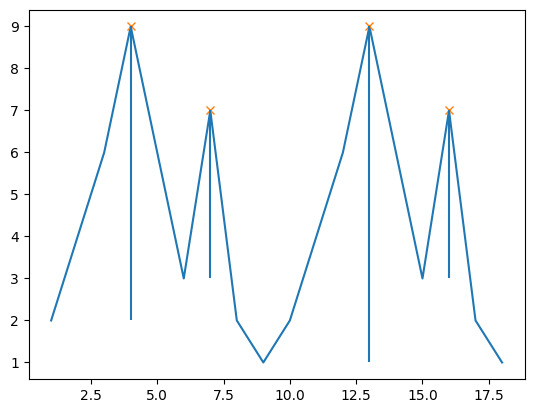

In [127]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_prominences

# サンプルデータを作成
data = np.array([ 2, 4, 6, 9, 6, 3, 7, 2, 1, 2, 4, 6, 9, 6, 3, 7, 2, 1], dtype=np.float64)
# data[4] = np.nan
print(data)
print(len(data))

datax = np.array([ 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18], dtype=np.float64)
print(len(datax))


# ピークを検出
peaks, _ = find_peaks(data)
print(peaks) #index

# ピークの突出度を計算
prominences = peak_prominences(data, peaks)[0]
print(prominences)

print(data[peaks])
contour_heights = data[peaks] - prominences

# 突出度を垂直な線でプロット
plt.plot(datax, data)
plt.plot(datax[peaks], data[peaks], "x")
plt.vlines(x=datax[peaks], ymin=contour_heights, ymax=data[peaks])
plt.show()
